# Datos del codigo:
* Estudiante: Juan Jose Valverde Campos
* Carnet: B47200
* Laboratorio 4 - CNN
* Profesor: Pablo Sauma Chacón

# Importación de Librerías

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch as pt 
# from torch.utils.data import dataset as Dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Se obtienen los datos con los cuales se va a trabajar

In [5]:
# Custom subdirectory to find images
DIRECTORY = "images"
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8') for n in unpickle(DIRECTORY+"/batches.meta")[b'label_names']]
    x_train = None
    y_train = []
    for i in range(1,6):
        data = unpickle(DIRECTORY+"/data_batch_"+str(i))
        if i>1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']
    data = unpickle(DIRECTORY+"/test_batch")
    x_test = data[b'data']
    y_test = data[b'labels']
    return names,x_train,y_train,x_test,y_test

names,x_train,y_train,x_test,y_test = load_data()
pt.manual_seed(29)
pt.cuda.manual_seed(29)

# Se obtiene la visualización de imágenes

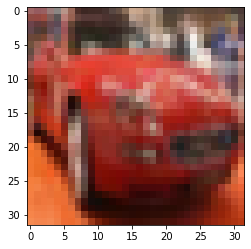

automobile


In [6]:
def plot_tensor(tensor, perm=None):
    if perm==None: perm = (1,2,0)
    plt.figure()
    plt.imshow(tensor.permute(perm).numpy().astype(np.uint8))
    plt.show()
images = pt.Tensor(x_train)
images = images.resize_(50000,3,32,32)
plot_tensor(images[5])
print(names[y_train[5]])


# Se crea la clase que va a ser llamada para entrenarse

In [7]:
# Se crea una clase que hereda de torch.nn.Module
# En el constructor se debe llamar al constructor padre  y crear sus capas
# Y se debe crear su método forward que ejecuta el paso de los datos por las neuronas


class SurvivorClassifier(pt.nn.Module):
	# def __init__(self, struct, activations,type):
	def __init__(self):
		super().__init__()
		# self.fc = []
		# self.act = []

		# self.fc1 = pt.nn.Linear(9, 5)
		# self.act1 = pt.nn.ReLU()
		# self.fc2 = pt.nn.Linear(5, 1)
		# self.act2 = pt.nn.Sigmoid()
		
		# 3 x 32 x 32 
		self.fc1 = pt.nn.Conv2d(3, 5, (5,5),padding= "same")
		self.act1 = pt.nn.ReLU()
		self.pool1 = pt.nn.AvgPool2d(2)
		# 5 x 16 x 16 
		self.fc2 = pt.nn.Conv2d(5, 7, (3,3),padding= "same")
		self.act2 = pt.nn.ReLU()
		self.pool2 = pt.nn.MaxPool2d(2)
		# 7 x 8 x 8
		self.fc3 = pt.nn.Conv2d(7, 5, (5,5),padding= "same")
		self.act3 = pt.nn.ReLU()
		self.pool3 = pt.nn.AvgPool2d(2)
		# 5 x 4 x 4
		self.fc4 = pt.nn.Conv2d(5, 3, (3,3),padding= "same")
		self.act4 = pt.nn.ReLU()
		self.pool4 = pt.nn.MaxPool2d(2)
		# 3 x 2 x 2
		self.fc5 = pt.nn.Linear(12, 10)
		self.act5 = pt.nn.Sigmoid()





	def forward(self, x):
		h1 = self.pool1(self.act1(self.fc1(x)))
		h2 = self.pool2(self.act2(self.fc2(h1)))
		h3 = self.pool3(self.act3(self.fc3(h2)))
		h4 = self.pool4(self.act4(self.fc4(h3)))
		h5 = self.fc5(h4.view(h4.size(0), -1) )# Repasar que se hizo .... (Tiene una entrada enorme....)
		return self.act5( h5 )
		# h = self.act1( self.fc1(x) )
		# out = self.act2( self.fc2(h) )
		# return out


# Se convierte los datos en tensores y se hace los batch de entrenamiento

In [8]:
names,x_train,y_train,x_test,y_test = load_data()
x_train = pt.Tensor(x_train)
y_train = pt.Tensor(y_train)
x_test = pt.Tensor(x_test)
y_test = pt.Tensor(y_test)
x_train = x_train.resize_(50000,3,32,32)
x_test = x_test.resize_(10000,3,32,32)

In [9]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y


    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
# traindata = MyDataset(x_train, y_train)
traindata = MyDataset(x_train, y_train)
testdata = MyDataset(x_test, y_test)
train_dataloader = DataLoader(traindata, batch_size=5000, shuffle=True)
test_dataloader = DataLoader(testdata, shuffle=True)

Se instancia el modelo y sus parametros

In [8]:
# model = SurvivorClassifier()	# Crea el modelo
# loss_fn = pt.nn.MSELoss()		# Función de error a utilizar
# optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador


# loss_train = []
# loss_test = []

# for i in range(100):
# 	train_features, train_labels = next(iter(train_dataloader))
# 	optimizer.zero_grad()			# Coloca los Δw en 0
# 	y_pred = model( train_features) # Predice los valores del conjunto de entrenamiento
# 	loss = loss_fn(y_pred.max(1).values, train_labels)	# Calcula la pérdida
# 	loss.backward()					# Calcula el backprogration (Δw) y acumula el error
# 	optimizer.step()				# Aplica los Δw acumulados y avanza un paso la iter. 
# 	with pt.no_grad():			# Apaga el cálculo de gradientes
# 		loss2 = loss_fn( model(x_test).max(1).values, y_test)
# 	loss_train.append(loss.item())
# 	loss_test.append(loss2.item())
# 	if(i%10 == 0):
# 		print(i)
# plt.plot(loss_train)
# plt.plot(loss_test)
# plt.show()

In [14]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels.long())
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            tb_x = epoch_index * len(train_dataloader) + i + 1
            running_loss = 0.
    return last_loss
    
def information(voutputs,y_test):
    answer = pt.argmax(voutputs, dim=1)
    correct = 0
    for i in range(y_test.size().numel()):
        if answer[i]==y_test[i]:
            correct +=1
    return correct / y_test.size().numel()

In [ ]:
# def train_one_epoch(epoch_index, tb_writer):
#     running_loss = 0.
#     last_loss = 0.

#     # Here, we use enumerate(training_loader) instead of
#     # iter(training_loader) so that we can track the batch
#     # index and do some intra-epoch reporting
#     for i, data in enumerate(train_dataloader):
#         # Every data instance is an input + label pair
#         inputs, labels = data

#         # Zero your gradients for every batch!
#         optimizer.zero_grad()

#         # Make predictions for this batch
#         outputs = model(inputs)

#         # Compute the loss and its gradients
#         loss = loss_fn(outputs, labels.long())
#         loss.backward()

#         # Adjust learning weights
#         optimizer.step()

#         # Gather data and report
#         running_loss += loss.item()
#         # if i % 1000 == 999:
#         #     last_loss = running_loss / 1000 # loss per batch
#         if i % 10 == 9:
#             last_loss = running_loss / 10 # loss per batch
#             # print('  batch {} loss: {}'.format(i + 1, last_loss))
#             tb_x = epoch_index * len(train_dataloader) + i + 1
#             # tb_writer('Loss/train', last_loss, tb_x)
#             tb_writer.add_scalar('Loss/train', last_loss, tb_x)
#             running_loss = 0.

#     return last_loss
# def information(voutputs,y_test):
#     answer = pt.argmax(voutputs, dim=1)
#     correct = 0
#     for i in range(y_test.size().numel()):
#         if answer[i]==y_test[i]:
#             correct +=1
#     return correct / y_test.size().numel()

EPOCH 1:
LOSS train 2.307378077507019 valid 2.303175926208496
Propotion: 0.1
entra
EPOCH 2:
LOSS train 2.299864387512207 valid 2.2843215465545654
Propotion: 0.1001
entra
EPOCH 3:
LOSS train 2.2492724418640138 valid 2.210629463195801
Propotion: 0.149
entra
EPOCH 4:
LOSS train 2.1972025632858276 valid 2.17624568939209
Propotion: 0.1684
entra
EPOCH 5:
LOSS train 2.1624134302139284 valid 2.1474502086639404
Propotion: 0.2142
entra
EPOCH 6:
LOSS train 2.1192856550216677 valid 2.1002461910247803
Propotion: 0.2171
entra
EPOCH 7:
LOSS train 2.080335998535156 valid 2.0826637744903564
Propotion: 0.227
entra
EPOCH 8:
LOSS train 2.068141460418701 valid 2.0618362426757812
Propotion: 0.234
entra
EPOCH 9:
LOSS train 2.057627463340759 valid 2.054023504257202
Propotion: 0.2459
entra
EPOCH 10:
LOSS train 2.052935838699341 valid 2.0485870838165283
Propotion: 0.2464
entra
EPOCH 11:
LOSS train 2.0477769136428834 valid 2.051215648651123
Propotion: 0.2483
EPOCH 12:
LOSS train 2.0468175649642943 valid 2.038961

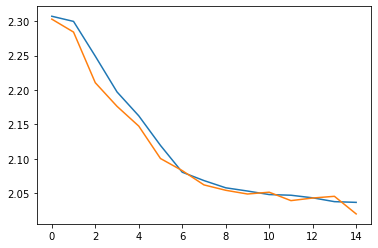

In [15]:
model = SurvivorClassifier()	# Crea el modelo
loss_fn = pt.nn.CrossEntropyLoss()		# Función de error a utilizar torch.
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador

loss_train = []
loss_test = []

EPOCHS = 15


def completeTrain(epoch_number,best_vloss):
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number)
        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        
        voutputs = model(x_test)
        vloss = loss_fn(voutputs, y_test.long())
        running_vloss += vloss

        avg_vloss = running_vloss

        loss_train.append(avg_loss)
        loss_test.append(vloss.item())

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Propotion: {}'.format(information(voutputs,y_test)))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("entra")
            best_vloss = avg_vloss
            pt.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_vloss,
            }, "myModel")

        epoch_number += 1
epoch_number = 0
best_vloss = 1_000_000.
completeTrain(epoch_number,best_vloss)

plt.plot(loss_train)
plt.plot(loss_test)
plt.show()

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
model = SurvivorClassifier()	# Crea el modelo
loss_fn = pt.nn.CrossEntropyLoss()		# Función de error a utilizar torch.
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
tensorBoard = False


EPOCHS = 5


def completeTrain(epoch_number,best_vloss):
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer)
        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        
        voutputs = model(x_test)
        vloss = loss_fn(voutputs, y_test.long())
        running_vloss += vloss


        # for i, vdata in enumerate(test_dataloader):
        #     vinputs, vlabels = vdata
        #     voutputs = model(vinputs)
        #     vloss = loss_fn(voutputs, vlabels.long())
        #     running_vloss += vloss
        avg_vloss = running_vloss
        # avg_vloss = running_vloss / (i + 1)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Propotion: {}'.format(information(voutputs,y_test)))
        # # Log the running loss averaged per batch
        # # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            print("entra")
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch_number)
            pt.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_vloss,
            }, "myModel")

        epoch_number += 1
epoch_number = 0
best_vloss = 1_000_000.
completeTrain(epoch_number,best_vloss)

EPOCH 1:
LOSS train 2.325866866111755 valid 2.303030014038086
Propotion: 0.1001
entra
EPOCH 2:
LOSS train 2.3028953790664675 valid 2.3023462295532227
Propotion: 0.1032
entra
EPOCH 3:
LOSS train 2.2962512493133547 valid 2.2784247398376465
Propotion: 0.1091
entra
EPOCH 4:
LOSS train 2.2687014818191527 valid 2.2511937618255615
Propotion: 0.184
entra
EPOCH 5:
LOSS train 2.2340232133865356 valid 2.2140378952026367
Propotion: 0.186
entra


In [67]:
checkpoint = pt.load("myModel")
model = SurvivorClassifier()
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = pt.optim.Adam(model.parameters(), lr=0.01)		# Optimizador
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
completeTrain(epoch_number,best_vloss)

EPOCH 1:
LOSS train 2.027310085296631 valid 2.03072452545166
Propotion: 0.2994
entra
EPOCH 2:
LOSS train 2.0283505439758303 valid 2.029451608657837
Propotion: 0.3039
entra
EPOCH 3:
LOSS train 2.024098587036133 valid 2.0321896076202393
Propotion: 0.301
EPOCH 4:
LOSS train 2.0260559797286986 valid 2.031386375427246
Propotion: 0.302
EPOCH 5:
LOSS train 2.0257518768310545 valid 2.029942274093628
Propotion: 0.2935
EPOCH 6:
LOSS train 2.026188540458679 valid 2.0310587882995605
Propotion: 0.3034
EPOCH 7:
LOSS train 2.0230552911758424 valid 2.0235776901245117
Propotion: 0.305
entra
EPOCH 8:
LOSS train 2.022961068153381 valid 2.033334493637085
Propotion: 0.3038
EPOCH 9:
LOSS train 2.0235159158706666 valid 2.0250356197357178
Propotion: 0.2996
EPOCH 10:
LOSS train 2.0209303379058836 valid 2.023073434829712
Propotion: 0.3003
entra
EPOCH 11:
LOSS train 2.019981288909912 valid 2.024655818939209
Propotion: 0.303
EPOCH 12:
LOSS train 2.019813561439514 valid 2.0201327800750732
Propotion: 0.3044
entra
E

In [12]:
checkpoint = pt.load("trueModel")
model = SurvivorClassifier()
model.load_state_dict(checkpoint["model_state_dict"])
model.train(False)
voutputs = model(x_test)
vloss = loss_fn(voutputs, y_test.long())
answers = pt.argmax(voutputs, dim=1)

RuntimeError: Error(s) in loading state_dict for SurvivorClassifier:
	Missing key(s) in state_dict: "fc4.weight", "fc4.bias". 
	size mismatch for fc3.weight: copying a param with shape torch.Size([10, 108]) from checkpoint, the shape in current model is torch.Size([5, 3, 3, 3]).
	size mismatch for fc3.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([5]).

In [18]:
import pandas as pd
import seaborn as sns
def calculate_confusion_matrix(predict, real):
    df = pd.DataFrame(index=names,columns=names).notnull().astype('uint') # df [c][f]
    for i in range(y_test.size().numel()):
        df[names[real[i].item()]] [names[predict[i].item()]]+=1
    
    return df.astype(int)
    # P =  Predict 
    # R =  Real 
    # [1 .(P=F,R=F) = ,2. (P=F,R=T)],[3. (P=T,R=F),4. (P=T,R=T)]
    # [4] [3]
    # [2] [1]
y_test = y_test.to(pt.int32)
voutputs = model(x_test)
predict = pt.argmax(voutputs, dim=1)
df = calculate_confusion_matrix(predict,y_test)

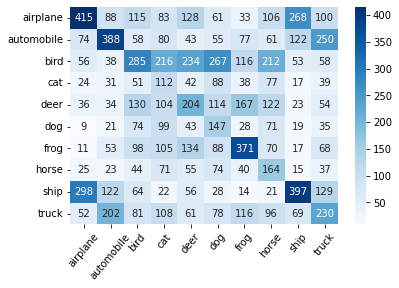

In [19]:
df
ax = sns.heatmap(df, annot=True,fmt='g', cmap='Blues')
sea = ax.set_xticklabels(ax.get_xticklabels(),rotation = 50)

Acurracy: 0.2713


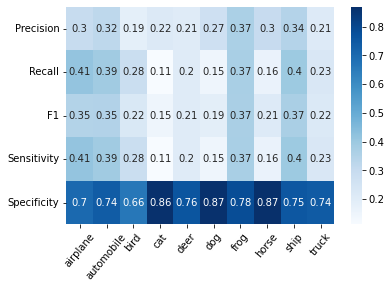

In [50]:
def getAccurracy(df):
    trues = np.diagonal(df)
    totalVal = df.values.sum() 
    return trues.sum() / totalVal


def getTP(df,Class):
    return df[Class][Class]

def getTN(df,Class):
    return np.diagonal(df).sum()-df[Class][Class]

def getFP(df,Class):
    return df[Class:Class].values.sum()-df[Class][Class]

def getFN(df,Class):
    return df[Class].values.sum()-df[Class][Class]


def getConfusionClass(df,Class,keys):
    tp = getTP(df,Class)
    tn = getTN(df,Class)
    fp = getFP(df,Class)
    fn = getFN(df,Class)
    prec = tp / (tp+fp)
    reca = tp / (tp+fn)
    return {
                keys[0]: prec,
                keys[1]:reca,
                keys[2]: 2 * prec*reca /(prec+reca),
                keys[3]: reca,
                keys[4]:tn/(tn+fp)
            }

keys = ["Precision","Recall","F1","Sensitivity","Specificity"]
statitics = {}
for i in keys:
    statitics[i] = []
for name in names:
    nameStatitics = getConfusionClass(df,name,keys)
    for key in statitics:
        statitics[key].append(nameStatitics[key])

print("Acurracy: {}".format(getAccurracy(df)))
stats = pd.DataFrame(statitics,index = names).transpose()
ax = sns.heatmap(stats, annot=True, cmap='Blues')
sea = ax.set_xticklabels(ax.get_xticklabels(),rotation = 50)